In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


IMPORT THE BASIC LIBRARIES

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [3]:
#Lets read the sample data from the audio using librosa
import librosa
audio_file = "/content/drive/MyDrive/Dataset/157.wav"
audio_data, audio_sample_rate = librosa.load(audio_file)
audio_data

array([ 2.1908805e-05, -5.1910043e-05, -6.1363331e-05, ...,
       -4.5554889e-06,  3.2918319e-06,  0.0000000e+00], dtype=float32)

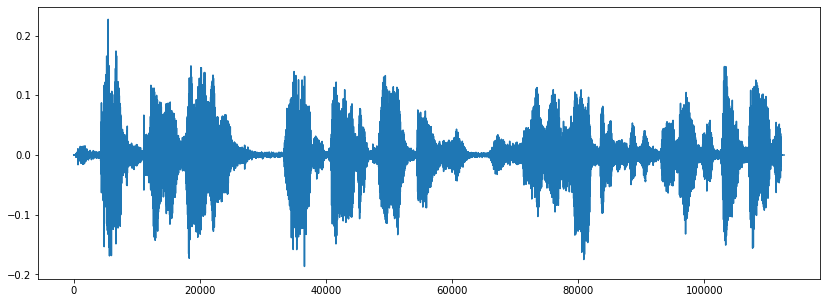

In [4]:
#lets plot the librosa audio data
plt.figure(figsize = (14,5))
plt.plot(audio_data)

## **Extract Features**

Here we will be using **Mel-Frequency-Cepstral-Coefficients (MFCC)** from the audio samples. The MFCC summarises the frequency distribution accross the window size, so it is possible to analyse both frequency and time characterstics of sound. These audio representations allow us to identify the features for classification.

It will try to convert the audio into some kind of features based on the frequency and time characterstics, which will helps us to do the classification.

In [5]:
mfcc = librosa.feature.mfcc(y = audio_data, sr = audio_sample_rate, n_mfcc = 40)  #n_mfcc can be any no. randomly
print(mfcc.shape)

(40, 220)


By executing the above line of code we can see all audio signal of the audio files are converted into the array of the dimensions (40,220)

In [6]:
mfcc

array([[-4.5982141e+02, -3.6349896e+02, -3.1940179e+02, ...,
        -2.7719009e+02, -3.3211719e+02, -4.1543869e+02],
       [ 6.6195465e+01,  3.9564667e+01,  3.3365135e+01, ...,
        -2.0864253e+00, -5.9096046e+01, -9.1608521e+01],
       [-2.2413015e+01, -2.0442844e+01, -1.6318405e+01, ...,
         3.7529362e+01,  7.3955048e+01,  1.0159946e+02],
       ...,
       [ 4.6472721e+00, -4.7898465e-01,  6.2748593e-01, ...,
         9.8104362e+00,  1.1225188e+01,  6.8496666e+00],
       [-9.4043427e+00, -7.7588811e+00, -4.7153502e+00, ...,
        -3.0425386e+00,  3.4132066e+00,  8.0588932e+00],
       [ 4.2936635e+00,  1.6038146e+00, -1.8735063e-01, ...,
         2.1842585e+00,  4.3648882e+00,  6.5833349e+00]], dtype=float32)

This is nothing but these are patterns has been extracted based on the frequency and time characterstics and this will uniquely identify that particular audio sinal, i/e from which class it actually belong...This audio signal will be later used in the deep learning techniques..

Now, this was only for a single file.... we are suppose to apply it on every file. 

For that we will first **Import the data from the `train_wav.csv`**

`train_wav.csv` is the file which we save (i.e train_wav.csv, test_wav.csv) while doing the EDA, where we replace all ".mp3" from the filename coulumn to ".wav"..

In [7]:
data_path = '/content/drive/MyDrive/Dataset/TrainAudio/'

mdata = pd.read_csv("/content/drive/MyDrive/Dataset/train_wav.csv",index_col=0)
mdata.head(10)

,filename,emotion
0,18777.wav,neutral
1,24041.wav,neutral
2,1621.wav,joy
3,28883.wav,neutral
4,14918.wav,neutral
5,25793.wav,neutral
6,8382.wav,joy
7,50666.wav,disgust
8,28471.wav,surprise
9,1459.wav,neutral


Now, I will define a function as **"feature_extractor"** which takes a `filename`, then in the function we will extract the audio data and the sample rate from *librosa.load()*, after that we will create features for the file using *mfcc *and at last finally to find out the scaled feature we will do the mean on the transpose of the particular *mfcc_features* that we are getting (it is a very important step)

In [8]:
def feature_extractor(file_name):
  audio_data, audio_sample_rate = librosa.load(file_name, res_type = 'kaiser_fast')
  mfcc_features = librosa.feature.mfcc(y = audio_data, sr = audio_sample_rate, n_mfcc = 40)
  mfcc_scaled_features = np.mean(mfcc_features.T, axis = 0)
  return mfcc_scaled_features

For applying this function in every audio file....I will iterate through the csv file... in order to do that i will perform the steps below

In [10]:
from tqdm import tqdm #by this library we can see the progress

# now we will iterate through every file to extract the features

extracted_features = []
fl = []

# i am going to iterate through mdata.iterrows(), iterrows function will help us to iter through all the rows of mdata
for index_num, row in tqdm(mdata.iterrows()): 
 
  #now we will join the path of the audio data (specified in above code as data_path) 
  #with the filename in the mdata dataframe so that it looks something like this: "TrainAudio/0.wav"
  filename = os.path.join(os.path.abspath(data_path), str(row['filename']))

  #then we are jut going to get the class (i.e emotion) as that is the output feature or the target variable 
  final_class_labels = row['emotion']
  fl.append(final_class_labels)

  #then we are going to create the independent features...i.e i am going to pass the file name in the feature_extractor function define in above cell
  #the output of the function is stored in the variable as "scaled_data"
  scaled_data = feature_extractor(filename)

  #then we will append the scaled_data with the final_class_labels list in the extacted_features list created above
  extracted_features.append(scaled_data)

  #The reason of appending the scaled_data and final_class in the extracted_features is because later on i will convert this into a dataframe


17it [00:00, 16.10it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
5816it [06:57, 13.92it/s]


Converting the extacted_feature list into a Dataframe

In [11]:
extracted_features_df = pd.DataFrame(extracted_features)
extracted_features_df['emotion'] = fl
extracted_features_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,emotion
0,-284.482758,126.683823,-36.903915,43.976826,-12.961371,8.616020,-10.584815,12.599451,-14.106994,2.853625,-19.962849,1.703447,-13.035324,-0.337073,-9.029764,2.131634,-8.832778,-1.266960,2.483978,4.040265,-2.574543,4.316617,5.576896,4.538510,-2.905437,-9.130464,-7.126249,-4.621140,1.610941,-1.597993,-4.868733,-4.488620,0.970274,5.310254,2.055159,-4.810302,-3.550115,-0.912865,0.987710,-3.169195,neutral
1,-291.756378,86.479385,-31.917055,28.526455,-21.277540,6.544608,-26.522366,0.857760,-19.578068,9.424254,-15.387749,-1.319279,-14.049103,3.400151,-9.289942,-1.578900,-10.043350,3.212034,-8.140825,-2.060176,-5.583338,-1.114504,-2.181613,0.425673,-0.556289,3.811432,0.392357,1.247997,-1.299044,-2.572325,-4.302300,-1.309161,-1.129280,-0.781117,0.173170,0.295313,0.099329,0.685805,-0.623442,-1.003877,neutral
2,-381.791229,125.338554,-13.164070,70.746918,-14.940821,0.121462,-15.981153,-1.870955,-17.828106,0.436152,-17.293005,5.565217,-11.894168,-2.076418,-5.616802,-4.331069,-10.762467,-5.230440,-8.456790,4.806179,-5.453306,-2.912219,3.964604,-2.836176,0.997076,1.716107,-3.087765,-1.639011,-1.344397,3.572985,8.062300,5.931730,9.156085,4.193003,-0.938635,-5.856699,-2.251703,-2.078479,1.565114,-3.527836,joy
3,-239.395355,117.492027,-47.426998,15.590010,-31.452276,10.473926,-15.031138,-3.744267,-13.968476,11.110762,-15.036322,0.180499,-14.177242,0.895325,-7.295934,-3.230096,-14.846791,0.266336,-5.302069,-0.801351,-4.021996,2.557503,-2.232066,-0.212296,-1.715083,0.353755,-1.177485,3.265667,2.864474,-0.795712,-1.337174,-0.222455,0.076919,2.235695,2.183837,-0.755808,-0.094991,0.606268,0.243874,-0.301148,neutral
4,-396.290375,87.998093,-8.710562,25.149500,-20.656134,19.762743,-8.971614,11.300339,-12.466163,15.747955,-8.156489,3.519957,-10.689272,8.925682,-10.783387,-0.155382,-6.888598,2.062116,-9.169439,0.586334,-1.464928,-2.857843,-4.133466,2.324855,-4.027257,-2.621431,-1.941476,0.106234,-1.970433,-1.547358,2.298595,1.576666,-0.154721,0.841168,0.910432,-1.836838,-2.386293,0.062624,-0.866900,-3.002568,neutral


Saving the file...

In [12]:
extracted_features_df.to_csv("extracted_features.csv")

## Do the Same for TestFile i.e. **test_wav.csv**

In [13]:
data_path = '/content/drive/MyDrive/Dataset/TestAudio/'

mdata = pd.read_csv("/content/drive/MyDrive/Dataset/test_wav.csv",index_col=0)
mdata.head(10)

,filename
0,26199.wav
1,692.wav
2,16821.wav
3,1608.wav
4,47947.wav
5,26679.wav
6,45080.wav
7,15385.wav
8,29210.wav
9,22481.wav


In [14]:
from tqdm import tqdm #by this library we can see the progress

# now we will iterate through every file to extract the features

extracted_features = []

# i am going to iterate through mdata.iterrows(), iterrows function will help us to iter through all the rows of mdata
for index_num, row in tqdm(mdata.iterrows()): 
 
  #now we will join the path of the audio data (specified in above code as data_path) 
  #with the filename in the mdata dataframe so that it looks something like this: "TestAudio/0.wav"
  filename = os.path.join(os.path.abspath(data_path), str(row['filename']))

  #then we are going to create the independent features...i.e i am going to pass the file name in the feature_extractor function define in above cell
  #the output of the function is stored in the variable as "scaled_data"
  scaled_data = feature_extractor(filename)

  #then we will append the scaled_data with the final_class_labels list in the extacted_features list created above
  extracted_features.append(scaled_data)

  #The reason of appending the scaled_data and final_class in the extracted_features is because later on i will convert this into a dataframe

2492it [03:08, 13.24it/s]


In [15]:
extracted_features_df = pd.DataFrame(extracted_features)
extracted_features_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,-365.498199,117.096603,-45.860619,26.170340,-19.327950,5.826083,-8.625709,3.698611,-9.505263,4.179258,-13.381192,-3.726986,-7.116247,3.226846,5.748386,1.476014,1.322597,4.594974,0.649197,-1.733015,0.814768,-0.299269,-6.527150,-4.502021,-3.637551,1.005939,2.376040,1.181016,5.352484,1.096276,-4.148792,-0.943505,1.336754,1.921744,2.171972,-0.493963,0.609537,-0.420111,-1.198725,-0.289114
1,-347.949188,119.581123,-64.870789,28.289196,-17.227034,1.405791,-19.127012,-0.037109,-4.695950,4.757370,-16.268415,12.414000,-8.603649,11.250471,-0.791979,-2.082313,-6.251864,-2.138777,-4.154130,-5.112389,-5.249875,-1.381801,-7.779440,1.614060,-2.386897,-2.998730,-3.988345,-1.523020,0.471276,0.553853,-2.383639,7.244662,2.767389,0.624551,-0.911286,-0.642175,2.007694,1.311860,0.557786,-1.679821
2,-246.307327,127.621956,-64.692360,26.010170,-21.393129,1.611420,-25.611008,-3.000171,-19.976074,13.602427,-20.220438,-1.328003,-8.998646,5.648849,-1.329489,2.937313,-9.322475,0.491171,-8.508337,-3.777499,1.956479,-4.159590,-4.693715,-2.616529,-8.337893,-8.267322,-6.528329,-8.053255,-8.756011,-4.309391,-5.639263,-7.899954,-6.496264,-1.968293,-1.530059,-4.412982,1.180403,-0.227306,-1.377517,-2.090379
3,-354.178925,115.171700,-29.250555,28.661533,-19.046085,14.314231,-15.076301,10.669386,-13.682147,8.825348,-7.674388,10.033533,-7.335188,5.590045,-3.345659,5.903026,-3.312939,2.215315,-3.286599,0.610735,-2.747557,-0.006787,-3.942774,-1.357584,-4.423564,-1.568985,-2.932627,-3.079486,-2.911442,-4.484192,-1.678067,-3.059764,-3.152131,-3.387888,-2.307304,-3.455725,-1.442823,-1.538246,0.305538,-0.026795
4,-402.002899,131.972260,-3.767405,57.126369,-5.330755,14.938948,-10.694655,-0.575818,-2.828084,-2.775017,5.426503,-11.814539,6.172842,-6.474564,-1.124049,-2.844613,-4.112265,0.511748,-2.982589,0.428808,-5.600098,1.815831,-1.625146,0.119953,3.307432,-0.293566,-0.053331,-0.411368,0.906042,-1.957615,1.770211,-0.503118,-0.532595,1.169265,-0.273719,2.817329,1.192993,0.105612,-0.235465,0.841233


In [16]:
extracted_features_df.to_csv("extracted_features_test.csv")

# **The data is ready for model training**